In [ ]:
# Run the code for a specific set of values and calculate the maximum and minimum value of the temperature during the probe.
# We must first determine the specific delay at which the THG signal is maximal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp
import glob

In [2]:
import models.graphene_thermodynamics_v2 as gt
from models.cooling_phonons_v3 import CoolingPhonons
from models.graphene_optics import GrapheneTHG

In [3]:
# Load interpolation data for the calculation of chemical potentials.
mm = gt.mu_func_use_2d_interpolation(load_from="mu_table.pkl")

In [4]:
run_label = "temp_estimate_probe"
time_stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
saveDir = "./data/05/%s_%s" % (time_stamp, run_label)
os.mkdir(saveDir)

In [5]:
# One time-evolution with pump and probe pulse.
def oneRun(x):
    dyn = CoolingPhonons(**x["sysparams"])
    # Integrate up to a bit later than the end of the probe pulse.
    tmax = x["sysparams"]["pr_delay"] + x["sysparams"]["pr_dt"] * 2.0
    runparams = {
        "tmax": tmax,
        "tnum": int(300 * tmax / 1.0e+4),  # proportional to 300 points for 10ps
        "dt_approx": 10.0,
        "print_time": False    
    }
    dyn.run(**runparams)    
    
    r = (x["il"], x["i_delay"], dyn.p["etaTHG_avg"])
    return r

In [6]:
# Generate a list of parameters to parallelize the calculation.
sysparams = {
    "tempK_eq": 30.0,
    "tau_ph": 1200.0,
    "pu_dt": 110.0,
    "pu_eph": 1.200,
    "pr_fluenceSI": 110.0,
    "pr_dt": 150.0,
    "pr_eph": 0.320,
    "nsub": 1.4,  # hBN encapsulated with SiO2 around
    "ntop": 1.4,
    "dtdb": 200.0,
    "ph_en_frac": 1.0,
    "dtdb_cutoff_dens": None
}

# List of delay values.
pr_delay_list = np.linspace(200.0, 1.0e+3, 21)
# List of parameters.
par_val_list = [
    {"eF": 0.050, "pu_fluenceSI": 10.0},
    {"eF": 0.050, "pu_fluenceSI": 60.0},
    {"eF": 0.050, "pu_fluenceSI": 200.0},    
    {"eF": 0.300, "pu_fluenceSI": 10.0},
    {"eF": 0.300, "pu_fluenceSI": 60.0},
    {"eF": 0.300, "pu_fluenceSI": 200.0}    
]

# Add the value of the delay, taken from the list, to the dictionary of sysparams.
params_list = []
for il,p in enumerate(par_val_list):
    for i_delay,pr_delay in enumerate(pr_delay_list):
        params_list.append({"il": il, "i_delay": i_delay, "saveDir": saveDir, "sysparams": {**sysparams, "eF": p["eF"], "pu_fluenceSI": p["pu_fluenceSI"], "pr_delay": pr_delay}})



In [7]:
# Run the calculation and save the results.
with mp.Pool(24) as p:
    res_list = p.map(oneRun, params_list)

In [10]:
# For each set of parameters, find the delay such that the THG is minimal.
# We do not normalize to the "unperturbed" THG (no pump) because it does not change
# the outcome of the minimization, since the reference THG value is the same.
thg_vals = np.zeros((len(pr_delay_list), len(par_val_list)))
for res in res_list:
    thg_vals[res[1],res[0]] = res[2]
i_delay_thg_min = [thg_vals[:,i].argmin() for i in range(len(par_val_list))]
delay_thg_min_list = [pr_delay_list[i] for i in i_delay_thg_min]
# Final list of parameters for the run, which includes Fermi energy, fluence, and delay.
par_val_2_list = [{**p, "pr_delay": delay} for delay,p in zip(delay_thg_min_list,par_val_list)]
for p in par_val_2_list:
    print(p)

{'eF': 0.05, 'pu_fluenceSI': 10.0, 'pr_delay': 200.0}
{'eF': 0.05, 'pu_fluenceSI': 60.0, 'pr_delay': 320.0}
{'eF': 0.05, 'pu_fluenceSI': 200.0, 'pr_delay': 440.0}
{'eF': 0.3, 'pu_fluenceSI': 10.0, 'pr_delay': 200.0}
{'eF': 0.3, 'pu_fluenceSI': 60.0, 'pr_delay': 240.0}
{'eF': 0.3, 'pu_fluenceSI': 200.0, 'pr_delay': 360.0}


In [14]:
# One time-evolution with pump and probe pulse.
# This time we need to save the time-evolution to analyze the temperature profiles.

def oneRun2(x):
    dyn = CoolingPhonons(**x["sysparams"])
    # Integrate up to a bit later than the end of the probe pulse.
    tmax = x["sysparams"]["pr_delay"] + x["sysparams"]["pr_dt"] * 2.0
    runparams = {
        "tmax": tmax,
        "tnum": 51,  # need more points
        "dt_approx": 5.0,
        "print_time": False    
    }
    dyn.run(**runparams)

    with open("%s/params-%02d.json" % (x["saveDir"], x["il"]), "w") as f:
        json.dump({"sysparams": x["sysparams"], "runparams": runparams}, f, indent=4)

    np.savetxt("%s/dynamics-%02d.csv" % (x["saveDir"], x["il"]), dyn.dynamics_m, delimiter=",")
    np.savetxt("%s/thg-%02d.csv" % (x["saveDir"], x["il"]), np.c_[dyn.p["pr_tt"],dyn.p["etaTHG"]], delimiter=",")
    
    r = x["il"]
    return r

In [15]:
# Create the list of complete parameters for the runs.
params_list = []
for il,p in enumerate(par_val_2_list):
    params_list.append({"il": il, "saveDir": saveDir, "sysparams": {**sysparams, "eF": p["eF"], "pu_fluenceSI": p["pu_fluenceSI"], "pr_delay": p["pr_delay"]}})


In [16]:
# Run the calculation and save the results.
with mp.Pool(6) as p:
    res_list2 = p.map(oneRun2, params_list)

In [17]:
# For each run, from the set of parameters, determine the initial and final time of the pulse.
time_brackets_list = []
for p in params_list:
    tmin = p["sysparams"]["pr_delay"]
    tmax = tmin + p["sysparams"]["pr_dt"]
    time_brackets_list.append([tmin, tmax])

In [35]:
# For each pulse, find maximum and minimum temperature in the appropriate time bracket,
# i.e. when the probe pulse is active.
temp_range_list = []
for i in range(len(params_list)):
    dyn = np.loadtxt("%s/dynamics-%02d.csv" % (saveDir, i), delimiter=",")
    tt = dyn[:,0]  # time mesh
    tmin, tmax = time_brackets_list[i]  # time bracket
    it_pr = np.where((tt>tmin) & (tt<tmax))  # time indices
    tempK_t = dyn[:,1]  # temperatures in time
    tempK_pr = tempK_t[it_pr]  # temperature in the time bracket
    tempK_min = np.round(tempK_pr.min(), decimals=-1)  # round to 10K
    tempK_max = np.round(tempK_pr.max(), decimals=-1)  # round to 10K
    temp_range_list.append([par_val_2_list[i]["eF"],par_val_2_list[i]["pu_fluenceSI"],tempK_min, tempK_max])
temp_range_list = np.array(temp_range_list)
print(temp_range_list)
np.savetxt("%s/temperature_range.csv" % saveDir, temp_range_list, fmt="%15.3f", delimiter=",",
           header="%13s,%15s,%15s,%15s" % ("eF[eV]", "F_pu[uJ/cm^2]", "Tmin[K]", "Tmax[K]"))

[[5.00e-02 1.00e+01 1.54e+03 1.82e+03]
 [5.00e-02 6.00e+01 1.97e+03 2.19e+03]
 [5.00e-02 2.00e+02 2.32e+03 2.45e+03]
 [3.00e-01 1.00e+01 9.40e+02 1.26e+03]
 [3.00e-01 6.00e+01 1.70e+03 1.86e+03]
 [3.00e-01 2.00e+02 2.21e+03 2.27e+03]]


Text(0, 0.5, '$T_{\\rm e}(t)~[{\\rm K}]$')

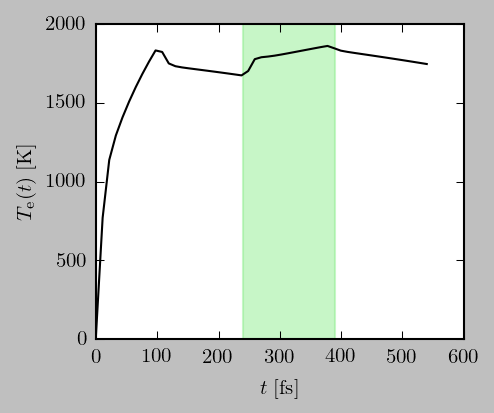

In [38]:
# Plot a curve to check.
i = 4
dyn = np.loadtxt("%s/dynamics-%02d.csv" % (saveDir, i), delimiter=",")
tt = dyn[:,0]
tempK_t = dyn[:,1]

mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.axvspan(time_brackets_list[i][0], time_brackets_list[i][1], alpha=0.5, color="#90ee90")
plt.plot(tt, tempK_t, "-k")
# plt.xlim([-100.0, 250.0])
# plt.ylim([0.0, 1600])
plt.xlabel(r"$t~[{\rm fs}]$")
plt.ylabel(r"$T_{\rm e}(t)~[{\rm K}]$")